In [2]:
! pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! mkdir ~/.kaggle

In [5]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download saurabhshahane/fake-news-classification

Dataset URL: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
License(s): Attribution 4.0 International (CC BY 4.0)
 89% 82.0M/92.1M [00:00<00:00, 192MB/s]
100% 92.1M/92.1M [00:00<00:00, 152MB/s]


In [9]:
! unzip fake-news-classification.zip

Archive:  fake-news-classification.zip
replace WELFake_Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
import pandas as pd
df=pd.read_csv("WELFake_Dataset.csv")
df_0=df[df['label']==0].sample(5000)
df_1=df[df['label']==1].sample(5000)
df=pd.concat([df_0, df_1])
df.head()

,Unnamed: 0,title,text,label
1017,1017,Indonesia foreign minister flies to Bangladesh...,DHAKA (Reuters) - Indonesia s foreign minister...,0
25562,25562,Islamic State claims responsibility for suicid...,BAGHDAD (Reuters) - Islamic State has claimed ...,0
62021,62021,Senator seeks explanation for career U.S. pros...,WASHINGTON (Reuters) - A Democratic Senator sa...,0
48907,48907,"Trump taps retired general, TV analyst for NSC...",(Reuters) - U.S. President-elect Donald Trump ...,0
52663,52663,Obama's EU envoy says Brexiteer Farage mislead...,BRUSSELS (Reuters) - Barack Obama’s envoy to B...,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1017 to 4969
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   title       9913 non-null   object
 2   text        9997 non-null   object
 3   label       10000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 390.6+ KB


# Missing data analysis

In [14]:
df.isnull().sum()

,0
Unnamed: 0,0
title,87
text,3
label,0


In [15]:
df=df.dropna()
df.isnull().sum()

,0
Unnamed: 0,0
title,0
text,0
label,0


In [16]:
df.shape

(9910, 4)

In [17]:
df.drop(columns=['Unnamed: 0'],inplace=True)
df.head()

,title,text,label
1017,Indonesia foreign minister flies to Bangladesh...,DHAKA (Reuters) - Indonesia s foreign minister...,0
25562,Islamic State claims responsibility for suicid...,BAGHDAD (Reuters) - Islamic State has claimed ...,0
62021,Senator seeks explanation for career U.S. pros...,WASHINGTON (Reuters) - A Democratic Senator sa...,0
48907,"Trump taps retired general, TV analyst for NSC...",(Reuters) - U.S. President-elect Donald Trump ...,0
52663,Obama's EU envoy says Brexiteer Farage mislead...,BRUSSELS (Reuters) - Barack Obama’s envoy to B...,0


# Class distribution

<Axes: ylabel='count'>

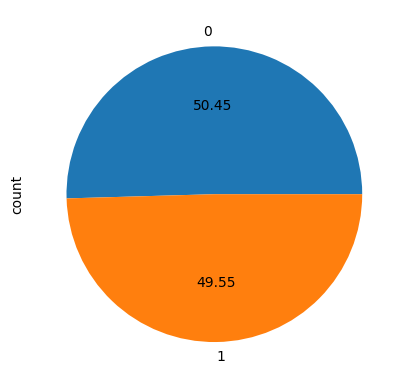

In [20]:
# 0 : Fake , 1: Real
df['label'].value_counts().plot.pie(autopct='%.2f')

We have a balanced data

In [22]:
X=df.drop(columns=['label'])
y=df['label']

In [23]:
messages=X.copy()
messages.reset_index(inplace=True)
messages.head()

,index,title,text
0,1017,Indonesia foreign minister flies to Bangladesh...,DHAKA (Reuters) - Indonesia s foreign minister...
1,25562,Islamic State claims responsibility for suicid...,BAGHDAD (Reuters) - Islamic State has claimed ...
2,62021,Senator seeks explanation for career U.S. pros...,WASHINGTON (Reuters) - A Democratic Senator sa...
3,48907,"Trump taps retired general, TV analyst for NSC...",(Reuters) - U.S. President-elect Donald Trump ...
4,52663,Obama's EU envoy says Brexiteer Farage mislead...,BRUSSELS (Reuters) - Barack Obama’s envoy to B...


# Cleaning Text

In [31]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

lm=WordNetLemmatizer()
ps=PorterStemmer()

corpus=[]
for i in range(len(messages)):
  review=re.sub('[^a-zA-Z0-9]',' ',messages['title'][i])
  review=review.lower()
  review=review.split()

  review= [lm.lemmatize(x) for x in review if x not in stopwords.words('english')]
  review=" ".join(review)
  corpus.append(review)



In [32]:
corpus[0:10]

['indonesia foreign minister fly bangladesh myanmar visit rohingya',
 'islamic state claim responsibility suicide attack southern iraq amaq',
 'senator seek explanation career u prosecutor abrupt resignation',
 'trump tap retired general tv analyst nsc post',
 'obama eu envoy say brexiteer farage misleading trump',
 'u senate panel suspends rule back price mnuchin cabinet',
 'canadian boy stripped bowling title color pant breitbart',
 'trump make day trip washington vacation white house',
 'jay h lehr beginning end epa',
 'u derivative regulator split white house budget']

In [33]:
print(sum(len(sentence.split()) for sentence in corpus))

90883


In [34]:
max_length= max(len(sentence.split()) for sentence in corpus)
print("Maximum sentence length is :",max_length)

Maximum sentence length is : 29


In [35]:
len(corpus)

9910

TF-IDF Vectorization

In [36]:
tf= TfidfVectorizer(max_features=5000)
x=tf.fit_transform(corpus).toarray()

In [37]:
x[0]

array([0., 0., 0., ..., 0., 0., 0.])

# Splitting into train and test sets

In [38]:
X_train,X_test,y_train,y_test= train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)


In [39]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [40]:
y_pred=rf.predict(X_test)


In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.8396    0.8430    0.8413      1000
           1     0.8395    0.8360    0.8378       982

    accuracy                         0.8396      1982
   macro avg     0.8396    0.8395    0.8395      1982
weighted avg     0.8396    0.8396    0.8396      1982



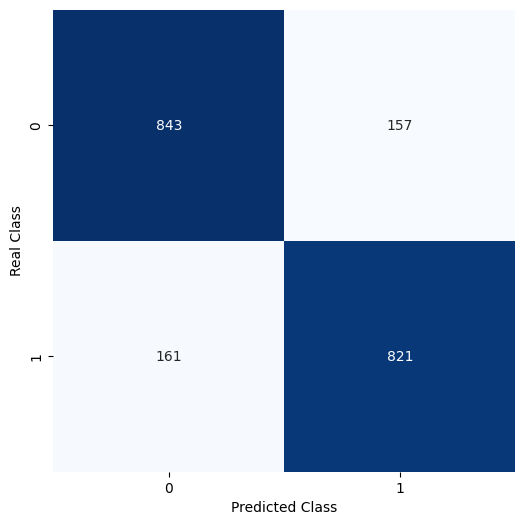

In [44]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt="d" ,cmap="Blues" ,cbar=False, square=True)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

In [46]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, classification_report

nb=MultinomialNB()
nb.fit(X_train,y_train)
y_pred_nb=nb.predict(X_test)
accuracy=accuracy_score(y_test,y_pred_nb)
precision=precision_score(y_test,y_pred_nb)
recall=recall_score(y_test,y_pred_nb)
f1=f1_score(y_test,y_pred_nb)

print("multinomialNB model ")
print("accuracy :",accuracy)
print("precision :",precision)
print("recall :",recall)
print("f1 :",f1)

multinomialNB model 
accuracy : 0.8511604439959637
precision : 0.8713513513513513
recall : 0.8207739307535642
f1 : 0.8453067645516518


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"{model_name} model ")
    print("Accuracy :", accuracy)
    print("Precision :", precision)
    print("Recall :", recall)
    print("F1 Score :", f1)

lr = LogisticRegression()
evaluate_model(lr, X_train, y_train, X_test, y_test, "Logistic Regression")


svc = SVC()
evaluate_model(svc, X_train, y_train, X_test, y_test, "SVC")


knn = KNeighborsClassifier()
evaluate_model(knn, X_train, y_train, X_test, y_test, "KNN")

dt = DecisionTreeClassifier()
evaluate_model(dt, X_train, y_train, X_test, y_test, "Decision Tree")

gb = GradientBoostingClassifier()
evaluate_model(gb, X_train, y_train, X_test, y_test, "Gradient Boosting")

ada = AdaBoostClassifier()
evaluate_model(ada, X_train, y_train, X_test, y_test, "AdaBoost")


voting = VotingClassifier(estimators=[
    ('lr', LogisticRegression()),
    ('svc', SVC()),
    ('knn', KNeighborsClassifier())
], voting='hard')
evaluate_model(voting, X_train, y_train, X_test, y_test, "Voting Classifier")


xgb = XGBClassifier()
evaluate_model(xgb, X_train, y_train, X_test, y_test, "XGBoost")

Logistic Regression model 
Accuracy : 0.8592330978809284
Precision : 0.8672936259143156
Recall : 0.845213849287169
F1 Score : 0.8561113976276431
--------------------------------------------------
SVC model 
Accuracy : 0.863773965691221
Precision : 0.8716075156576201
Recall : 0.8503054989816701
F1 Score : 0.8608247422680413
--------------------------------------------------
KNN model 
Accuracy : 0.5045408678102926
Precision : 0.5
Recall : 1.0
F1 Score : 0.6666666666666666
--------------------------------------------------
Decision Tree model 
Accuracy : 0.79313824419778
Precision : 0.8004201680672269
Recall : 0.7759674134419552
F1 Score : 0.7880041365046536
--------------------------------------------------
Gradient Boosting model 
Accuracy : 0.7921291624621595
Precision : 0.7526595744680851
Recall : 0.8645621181262729
F1 Score : 0.804739336492891
--------------------------------------------------
AdaBoost model 
Accuracy : 0.6892028254288597
Precision : 0.9463414634146341
Recall : 0.39

In [ ]:
from sklearn.ensemble import StackingClassifier

base_models=[
    ('lr',lr),
    ('knn',knn),
    ('dt',dt),
    ('gb',gb),
    ('ada',ada)
]

meta_model=LogisticRegression()

stacking_classifier=StackingClassifier(
    estimators=base_models , final_estimator=meta_model
)
stacking_classifier.fit(X_train,y_train)
y_pred_stack=stacking_classifier.predict(y_test)

In [ ]:
accuracy_stack = accuracy_score(y_test, y_pred_stack)
precision_stack = precision_score(y_test, y_pred_stack)
recall_stack = recall_score(y_test, y_pred_stack)
f1_stack = f1_score(y_test, y_pred_stack)


print("Accuracy :", accuracy_stack)
print("Precision :", precision_stack)
print("Recall :", recall_stack)
print("F1 Score :", f1_stack)